# Arabic Sign Language Image Classifier 🤟🇸🇦
A machine learning project to classify Arabic hand gesture images into corresponding letters using multiple models, selecting the best one, and deploying it with a Gradio interface.


### 📦 Step 0: Importing Required Libraries

All necessary libraries were imported to handle:

- **System utilities** (`os`)
- **Image processing** (`PIL`)
- **Data manipulation** (`numpy`, `pandas`, `tqdm`)
- **Visualization** (`matplotlib`, `seaborn`)
- **Machine learning models** (`LogisticRegression`, `RandomForestClassifier`, `SVC`, `KNeighborsClassifier`, `XGBClassifier`)
- **Model evaluation & selection** (`GridSearchCV`, `PCA`, `train_test_split`, evaluation metrics)
- **Preprocessing** (`StandardScaler`, `LabelEncoder`)
- **Model deployment** (`gradio`, `joblib`)


In [22]:
# OS and system utilities
import os

# Data manipulation and preprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm

# Image processing
from PIL import Image

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model selection and evaluation
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.model_selection import GridSearchCV, train_test_split,learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Deployment
import gradio as gr
import joblib


### 🔍 Step 1: Preprocessing and Data Loading

Defined two functions:
- `preprocess_image`: Converts images to grayscale, resizes, and normalizes.
- `load_images`: Loads and preprocesses all images from the dataset directory.

Then we loaded the full dataset and printed the image and label shapes for verification.


In [18]:
# Function to load the images from a folder
def load_images(folder_path, image_size=(64, 64)):
    x = []
    y = []

    for label in sorted(os.listdir(folder_path)):
        label_path = os.path.join(folder_path, label)
        if not os.path.isdir(label_path):
            continue

        for file in sorted(os.listdir(label_path)):
            file_path = os.path.join(label_path, file)

            if not os.path.isfile(file_path):
                continue
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                continue

            # Preprocess one image
            img_array = preprocess_image(file_path, image_size)

            # Append result
            x.append(img_array)
            y.append(label)

    return np.array(x), np.array(y)


In [17]:
# Functiom to preprocess the image
def preprocess_image(file_path,gui=False, image_size=(64, 64)):
    # Open image, convert to grayscale and resize
    img = Image.open(file_path).convert("L")
    img = img.resize(image_size)
    img_normal = np.array(img) / 255.0  # Normalize
    return img_normal.flatten()


In [19]:
# Quality Check part >>
x , y = load_images("C:/Users/menna/Downloads/archive/ArASL_Database_54K_Final/ArASL_Database_54K_Final", (64, 64))
print("Images loaded:", x.shape)
print("Labels loaded:", y.shape)


Images loaded: (54049, 4096)
Labels loaded: (54049,)


### 🔍 Visualizing Sample Images

To verify that the images have been correctly preprocessed, we display a selection of sample images along with their corresponding labels. This step ensures that the images are loaded, resized to 64×64 pixels, converted to grayscale, and flattened properly.


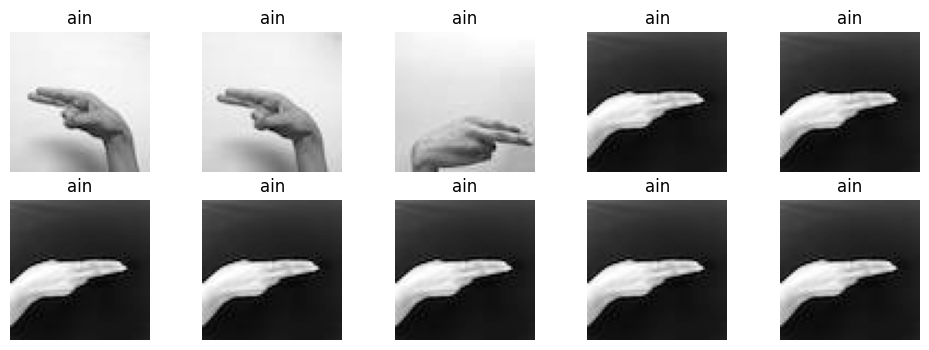

In [31]:
def show_samples(x, y, n_samples=10):
  plt.figure(figsize=(12, 4))
  for i in range(n_samples):
    plt.subplot(2, 5, i+1)
    plt.imshow(x[i].reshape(64, 64), cmap="gray")
    plt.title(y[i])
    plt.axis("off")
  plt.show()

show_samples(x , y)

### ⚖️ Class Distribution Analysis

To better understand the dataset, we examine the distribution of images across different Arabic sign language letters. 


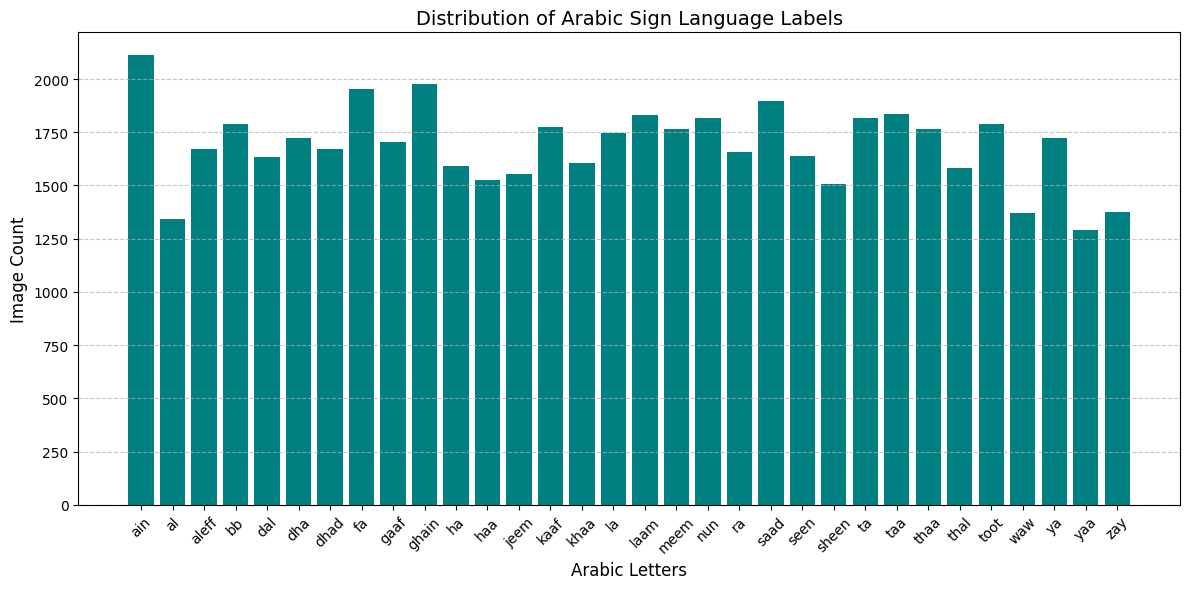

In [33]:
from collections import Counter
import matplotlib.pyplot as plt

# Count how many times each Arabic letter appears
label_counts = Counter(y)

# Sort labels alphabetically (or by custom order if needed)
sorted_labels = sorted(label_counts.keys())
counts = [label_counts[label] for label in sorted_labels]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(sorted_labels, counts, color='teal')
plt.title('Distribution of Arabic Sign Language Labels', fontsize=14)
plt.xlabel('Arabic Letters', fontsize=12)
plt.ylabel('Image Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


 This reveals that the dataset is **imbalanced**, with some letters having significantly more samples than others.  
Knowing this is crucial as it may affect model performance and requires consideration during model training and evaluation.

### 🧹 Step 2:  Data Preprocessing

Before training our models, we apply several preprocessing steps:

- **Label Encoding**: Converts categorical Arabic letters into numerical labels suitable for model training.
- **Train-Test Split**: Divides the dataset into training and testing subsets (70% train, 30% test).
- **Feature Scaling**: Uses `StandardScaler` to normalize pixel values, ensuring better performance in distance-based models and PCA.
- **Dimensionality Reduction (PCA)**: Applies Principal Component Analysis to retain 95% of the variance while reducing the number of features, which helps speed up training and may improve accuracy.


In [32]:
# Applying LabelEncoding to the labels to ease the model training process and aim to higher accuracy
preprocess = LabelEncoder()
y = preprocess.fit_transform(y)

In [33]:
# Preparing the data for training by splitting into a training set and a testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(f"train shape {x_train.shape} and test shape {x_test.shape}")

train shape (37834, 4096) and test shape (16215, 4096)


In [34]:
# Scale the data with Standardscaler to improve trainig
def scale_data(x_train,x_test,scaler=StandardScaler()):
  x_train_scaled = scaler.fit_transform(x_train)
  x_test_scaled = scaler.transform(x_test)
  return x_train_scaled,x_test_scaled,scaler

In [35]:
# Applying PCA to pixel-transformed values aimimg to dimensionality reduction, however, keeping in shape
def pca(x_train,x_test,pca=PCA(n_components=0.95)):
  # scale data before pca,Without scaling, PCA might focus more on high-magnitude features, not informative ones.
  x_train_scaled,x_test_scaled,scaler = scale_data(x_train,x_test)
  x_train_pca = pca.fit_transform(x_train_scaled)
  x_test_pca = pca.transform(x_test_scaled)
  print("Original shape:", x_train.shape)
  print("PCA shape:", x_train_pca.shape)
  return x_train_pca,x_test_pca,scaler,pca

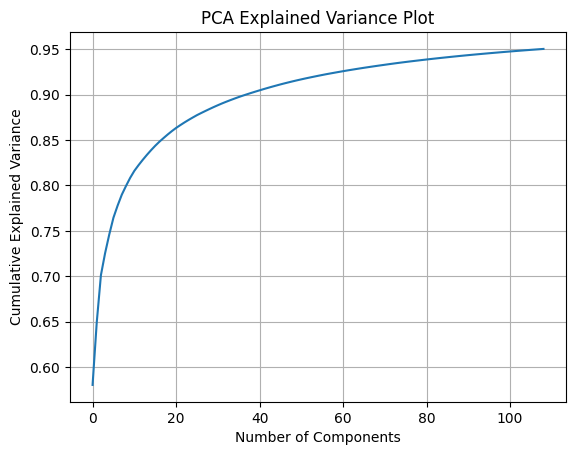

In [21]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance Plot')
plt.grid(True)
plt.show()

This curve shows how much information (variance) we keep as we add more PCA components.

We chose to keep 95% of the total variance, which reduced the features from 4096 to 109. This helps make the model faster and still accurate.

PCA helps:
- Remove unnecessary data
- Make training faster
- Keep important information only

In [36]:
X_train,X_test,scaler,pca = pca(x_train,x_test)

Original shape: (37834, 4096)
PCA shape: (37834, 109)


### 🔧 Step 3:  Model Training & Hyperparameter Tuning

To identify the best-performing model for Arabic Sign Language classification, we trained four different machine learning models:

- **Support Vector Machine (SVM)**
- **Random Forest**
- **K-Nearest Neighbors (KNN)**
- **XGBoost**

For each model, we used **GridSearchCV** with 3-fold cross-validation to search for the optimal hyperparameters. This ensures better generalization by evaluating multiple parameter combinations.

The training was done on the **PCA-transformed features**, which helps reduce dimensionality and training time while preserving essential information.

Each model's best parameters, best estimator, and cross-validation score were saved for comparison.


In [ ]:
# Different models and parameters to Hypertune every model of them
models = {
    'Svm': {
        'model': SVC(),
        'param': {
            'C': [0.1, 1],               # regularization
            'kernel': ['rbf', 'linear'],     # try both kernels
            'gamma': ['scale', 'auto']       # only for rbf
        }
    },

    'Random_forest': {
        'model': RandomForestClassifier(),
        'param': {
            'n_estimators': [50, 100],       # number of trees
            'max_depth': [None, 10],     # depth of each tree
            'min_samples_split': [2, 5],     # min samples to split
        }
    },

    'Knn': {
        'model': KNeighborsClassifier(),
        'param': {
            'n_neighbors': [3, 5],        # number of neighbors
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },

    'XGboost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'param': {
            'n_estimators': [50, 100],
            'max_depth': [3, 6],
            'learning_rate': [0.1, 0.3]
        }
    }
}

In [ ]:
def run_different_models(models_dict, X_train, y_train):
    scores = []
    model_items = list(models_dict.items())

    for name, model in tqdm(model_items, desc="Tuning models", unit="model"):
        print(f"\nRunning: {name}")
        gs = GridSearchCV(estimator=model['model'],
                          param_grid=model['param'],
                          n_jobs=-1,
                          cv=3,
                          verbose=2)
        gs.fit(X_train, y_train)
        scores.append({
            'model': name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_,
            'best_estimator': gs.best_estimator_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params', 'best_estimator'])

In [52]:
df = run_different_models(models,X_train,y_train)

Tuning models:   0%|          | 0/4 [00:00<?, ?model/s]


Running: Svm
Fitting 2 folds for each of 8 candidates, totalling 16 fits


Tuning models:  25%|██▌       | 1/4 [21:28<1:04:26, 1288.92s/model]


Running: Random_forest
Fitting 2 folds for each of 8 candidates, totalling 16 fits


Tuning models:  50%|█████     | 2/4 [23:32<20:07, 603.68s/model]   


Running: Knn
Fitting 2 folds for each of 8 candidates, totalling 16 fits


Tuning models:  75%|███████▌  | 3/4 [24:08<05:44, 344.44s/model]


Running: XGboost
Fitting 2 folds for each of 8 candidates, totalling 16 fits


Tuning models: 100%|██████████| 4/4 [27:20<00:00, 410.16s/model]


### 🔍 Step 4:  Comparing Model Performance

In this section, we compare the accuracy scores of the four different machine learning models trained on our dataset. The table below (`df`) summarizes each model along with its best accuracy score obtained from cross-validation.

To better visualize and compare these scores, we also plot a bar chart showing the accuracy of each model. This helps us quickly identify which model performed best overall.


In [54]:
df

,model,best_score,best_params,best_estimator
0,Svm,0.916001,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}","SVC(C=1, gamma='auto')"
1,Random_forest,0.919755,"{'max_depth': None, 'min_samples_split': 2, 'n...","(DecisionTreeClassifier(max_features='sqrt', r..."
2,Knn,0.930486,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...","KNeighborsClassifier(metric='euclidean', n_nei..."
3,XGboost,0.907728,"{'learning_rate': 0.3, 'max_depth': 6, 'n_esti...","XGBClassifier(base_score=None, booster=None, c..."


C:\Users\menna\AppData\Local\Temp\ipykernel_19344\921190474.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model',y='best_score',data=df, palette='viridis')


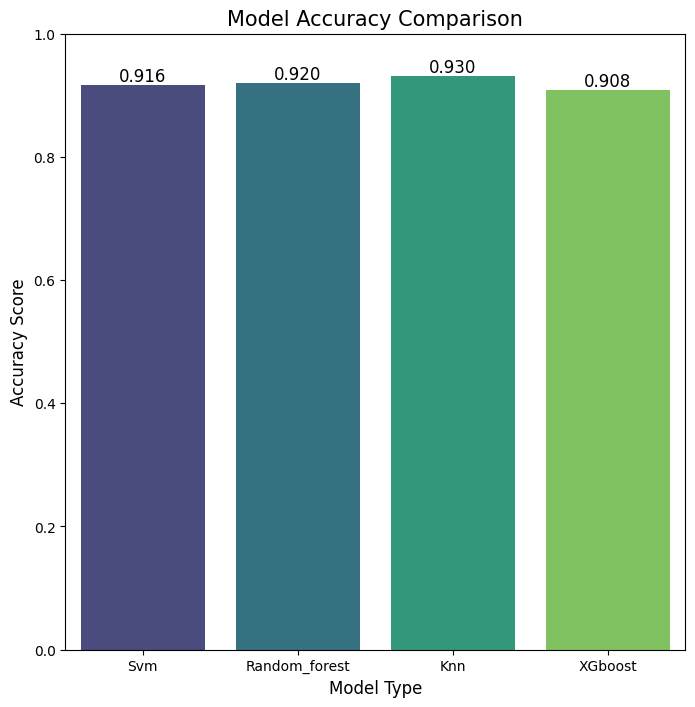

In [55]:
# barplot to compare the models scores
plt.figure(figsize=(8,8))
sns.barplot(x='model',y='best_score',data=df, palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=15)
plt.ylim(0, 1.0)  # Since accuracy is between 0 and 1
plt.xlabel('Model Type', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)

# Add value labels on top of bars
for index, row in df.iterrows():
    plt.text(index, row['best_score'], f"{row['best_score']:.3f}",
             ha='center', va='bottom', fontsize=12)

### ✅ Best Model: K-Nearest Neighbors (KNN)

After comparing the accuracy scores of all models, the KNN model achieved the highest performance. 

Now, we will move forward with a deeper evaluation of the KNN model using various metrics and visualizations, including:

- Learning Curve
- ROC Curve (Micro and Macro Averages)
- Confusion Matrix and Classification Report Heatmap

These evaluations will help us understand how well the KNN model generalizes, handles class imbalance, and performs across all classes.


In [ ]:
# choosing the best model based on the highest score
print("\nBest Model:")
knn_best_model = df.loc[df['best_score'].idxmax()]['best_estimator']
y_pred = knn_best_model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy of the best model: {accuracy:.4f}")


Best Model:
Accuracy of the best model: 0.9448


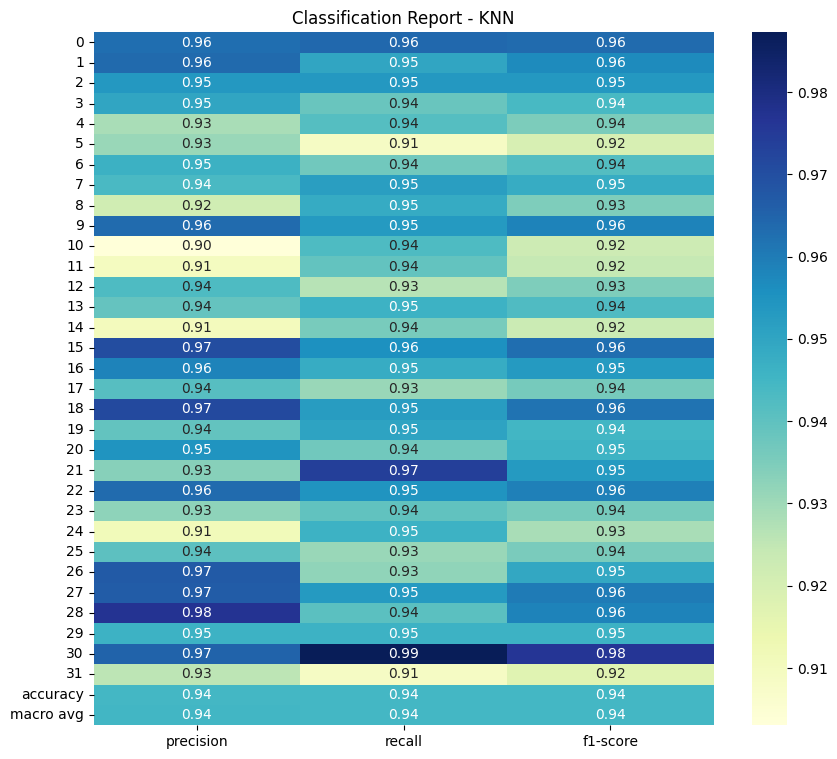

In [65]:
# Create classification report as dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Drop support column for heatmap (optional)
plt.figure(figsize=(10, 9))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report - KNN")
plt.show()

 The scores are mostly high (close to 1.0), which means the model is performing well for most classes.


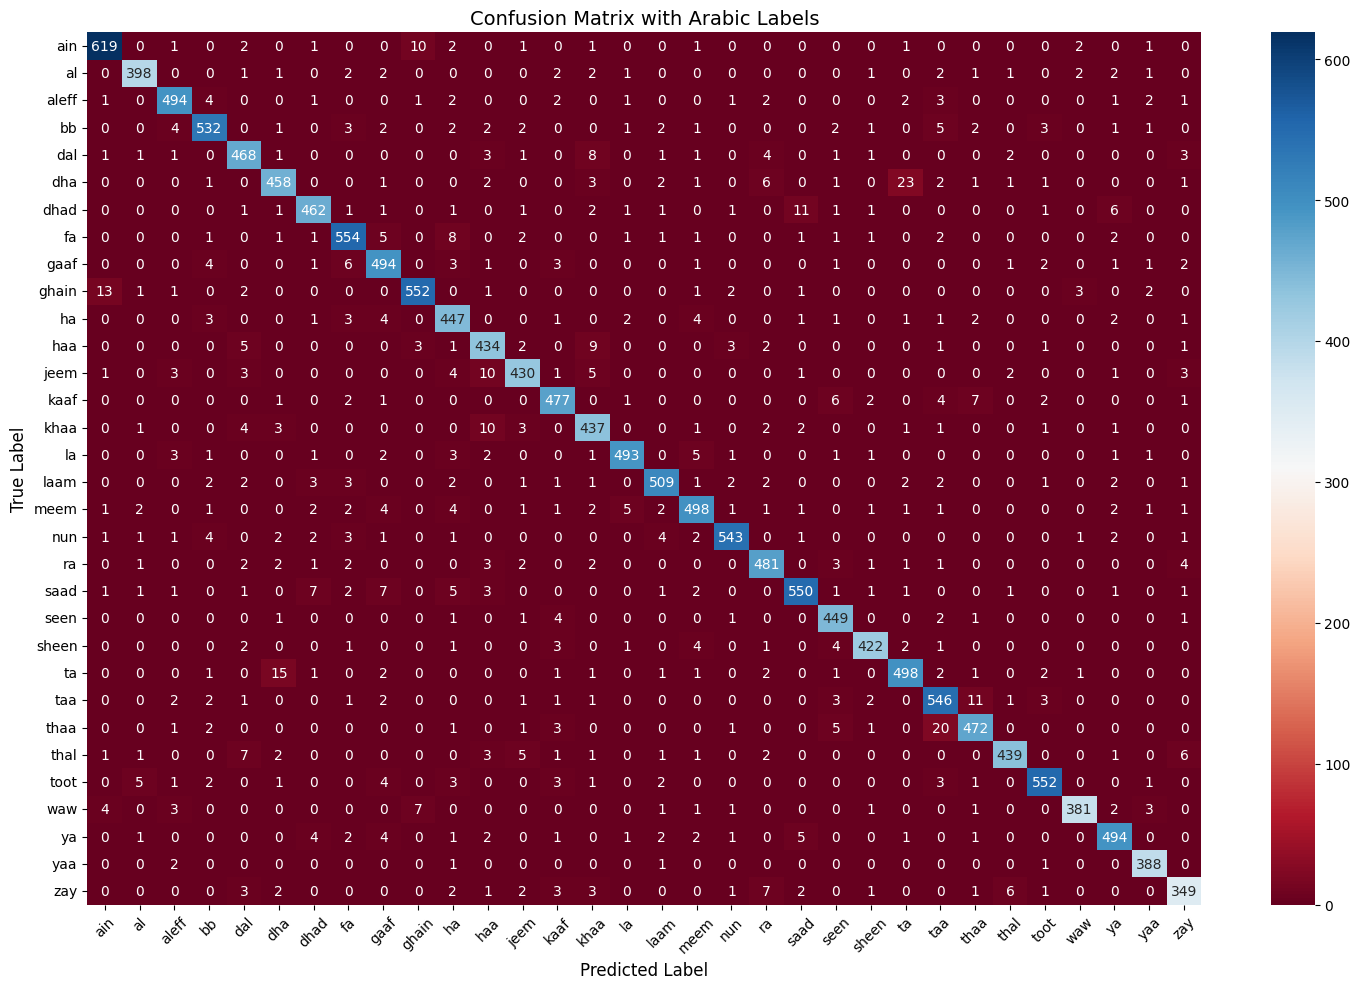

In [59]:
y_test_letters = preprocess.inverse_transform(y_test)
y_pred_letters = preprocess.inverse_transform(y_pred)
sorted_labels = sorted(np.unique(y_test_letters))

# Generate the matrix with proper Arabic labels
cm = confusion_matrix(y_test_letters, y_pred_letters, labels=sorted_labels)

# Plot the confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdBu',
            xticklabels=sorted_labels, yticklabels=sorted_labels)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix with Arabic Labels", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


- The model did a great job on most letters.
- For example:
  - `ain`: 619 correct
  - `fa`: 554 correct
  - `ghain`: 552 correct

- `dha` was sometimes predicted as `ghain` (23 times)
- `ta` was confused with `thaa` (15 times)

The model is working well, but we can improve it by helping it learn the confusing letters better.

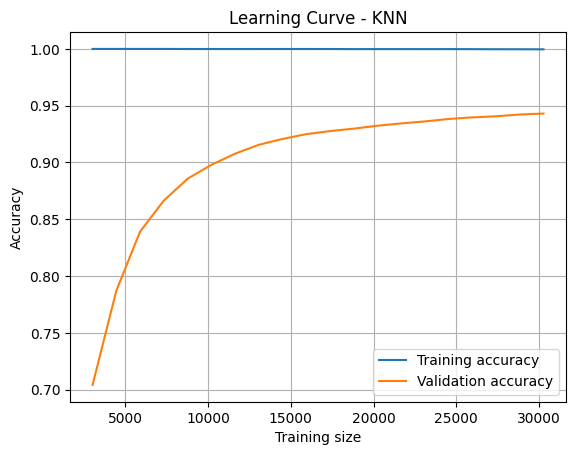

In [62]:
# Learning Curves for KNN

train_sizes, train_scores, test_scores = learning_curve(
    knn_best_model, X=X_train, y=y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 20), n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training accuracy")
plt.plot(train_sizes, test_scores_mean, label="Validation accuracy")
plt.xlabel("Training size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - KNN")
plt.legend()
plt.grid(True)
plt.show()


### 💾 Step 5:  Saving and Loading the Best Model

To ensure reusability and avoid retraining the model every time, we save the best-performing KNN model along with the preprocessing tools used during training:

- The trained **KNN model**
- The **Label Encoder** used to encode the target labels
- The **StandardScaler** used for feature scaling
- The **PCA** object used for dimensionality reduction

We then reload these objects when needed for evaluation or deployment.


In [52]:
# save the model
joblib.dump(knn_best_model, 'best_model_knn.pkl')
joblib.dump(preprocess, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')                     # StandardScaler
joblib.dump(pca, 'pca.pkl')                           # PCA

['pca.pkl']

In [53]:

# Load saved model and label encoder
model = joblib.load('best_model_knn.pkl')
le = joblib.load('label_encoder.pkl')
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')


### 🖼️ Step 6: Image Prediction and Gradio Interface

After training and saving the best KNN model, we now create a pipeline to classify new Arabic sign language images.

- `preprocess_image`: Prepares the input image by converting it to grayscale, resizing it, normalizing pixel values, applying scaling and PCA.
- `predict_image`: Uses the loaded model to make predictions and returns the top probable classes (if available).
- **Gradio Interface**: A simple and interactive UI is built using Gradio to allow users to upload an image and see the model's prediction instantly.

This allows for easy testing and demonstration of the model in action.


In [10]:

def preprocess_image(image, image_size=(64, 64)):
    # Ensure image is a PIL Image (convert from NumPy if needed)
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    img = image.convert("L")               # Convert to grayscale
    img = img.resize(image_size)           # Resize
    img_array = np.array(img) / 255.0  
    # Normalize
    flat = img_array.flatten().reshape(1, -1)
    scaled = scaler.transform(flat)
    pca_img = pca.transform(scaled)
    return pca_img


In [11]:

def predict_image(img):
    processed = preprocess_image(img)
    class_names = le.classes_

    if hasattr(model, "predict_proba"):  # check if model supports probabilities
        probs = model.predict_proba(processed)[0]
        top_n = 5 if len(probs) >= 5 else len(probs)
        return {class_names[i]: float(probs[i]) for i in np.argsort(probs)[::-1][:top_n]}
    else:
        pred = model.predict(processed)
        return {le.inverse_transform(pred)[0]: 1.0}

In [ ]:
# Define input image component
image_input = gr.Image(
    image_mode="L",               # "L" for grayscale image
    label="Upload Arabic Sign Image"
)

# Output label
label_output = gr.Label()

# Create the interface
interface = gr.Interface(
    fn=predict_image,             # Your prediction function
    inputs=image_input,
    outputs=label_output,
    title="Arabic Sign Language Classifier",
    description="Upload a hand gesture image to classify the Arabic letter.",

    live=False
)

interface.launch(debug=True)


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
